In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, ward, average, weighted, leaves_list
from scipy.spatial.distance import pdist
import networkx as nx

In [3]:
# file_path = '/Users/Annaliese/Desktop/PopGenStats_Project/data/BifidoIsolates/BLongum/skani_ani_edge_list.tsv'
file_path = '/Users/Annaliese/Desktop/PopGenStats_Project/data/OneDrive-2024-08-01/blongum/distances/skani.tsv'

skani_matrix = pd.read_csv(file_path, sep='\t')

sample_names = sorted(set(skani_matrix['Ref_file']) | set(skani_matrix['Query_file']))
mapper = {name: f'sample{idx}' for idx, name in enumerate(sample_names)}

skani_matrix['ref'] = skani_matrix['Ref_file'].map(mapper)
skani_matrix['query'] = skani_matrix['Query_file'].map(mapper)

skani_matrix['score1'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_ref'] / 100)
skani_matrix['score2'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_query'] / 100)

skani_matrix

Ref_file  \
0       /charonfs/scratch/users/astar/gis/ericejs/proj...   
1       /charonfs/scratch/users/astar/gis/ericejs/proj...   
2       /charonfs/scratch/users/astar/gis/ericejs/proj...   
3       /charonfs/scratch/users/astar/gis/ericejs/proj...   
4       /charonfs/scratch/users/astar/gis/ericejs/proj...   
...                                                   ...   
188186  /charonfs/scratch/users/astar/gis/ericejs/proj...   
188187  /charonfs/scratch/users/astar/gis/ericejs/proj...   
188188  /charonfs/scratch/users/astar/gis/ericejs/proj...   
188189  /charonfs/scratch/users/astar/gis/ericejs/proj...   
188190  /charonfs/scratch/users/astar/gis/ericejs/proj...   

                                               Query_file    ANI  \
0       /charonfs/scratch/users/astar/gis/ericejs/proj...  98.73   
1       /charonfs/scratch/users/astar/gis/ericejs/proj...  98.43   
2       /charonfs/scratch/users/astar/gis/ericejs/proj...  98.74   
3       /charonfs/scratch/users/astar/gis/ericejs/proj...  98.60   
4       /charonfs/scratch/users/astar/gis/ericejs/proj...  98.84   
...                                                   ...    ...   
188186  /charonfs/scratch/users/astar/gis/ericejs/proj...  98.74   
188187  /charonfs/scratch/users/astar/gis/ericejs/proj...  98.90   
188188  /charonfs/scratch/users/astar/gis/ericejs/proj...  98.50   
188189  /charonfs/scratch/users/astar/gis/ericejs/proj...  98.89   
188190  /charonfs/scratch/users/astar/gis/ericejs/proj...  98.59   

        Align_fraction_ref  Align_fraction_query  \
0                    83.96                 78.95   
1                    83.84                 78.57   
2                    82.42                 79.50   
3                    82.91                 81.25   
4                    84.66                 81.85   
...                    ...                   ...   
188186               86.11                 84.17   
188187               84.12                 85.80   
188188               84.51                 79.61   
188189               87.36                 85.83   
188190               88.17                 81.97   

                                                 Ref_name  \
0                 contig_1 rotated=True rotated_gene=dnaA   
1                 contig_1 rotated=True rotated_gene=dnaA   
2                 contig_1 rotated=True rotated_gene=dnaA   
3                 contig_1 rotated=True rotated_gene=dnaA   
4                 contig_1 rotated=True rotated_gene=dnaA   
...                                                   ...   
188186  NZ_JAERWG010000001.1 Bifidobacterium longum su...   
188187  NZ_JAERWG010000001.1 Bifidobacterium longum su...   
188188  NZ_JAERWG010000001.1 Bifidobacterium longum su...   
188189  NZ_JAERWG010000001.1 Bifidobacterium longum su...   
188190  NZ_JAERWG010000001.1 Bifidobacterium longum su...   

                                               Query_name        ref  \
0       NZ_PJED01000001.1 Bifidobacterium longum strai...    sample0   
1       NZ_SHTT01000001.1 Bifidobacterium longum subsp...    sample0   
2       NZ_WMFR01000010.1 Bifidobacterium longum subsp...    sample0   
3       CAUBFY010000001.1 MAG TPA_asm: Bifidobacterium...    sample0   
4       NZ_SHRW01000001.1 Bifidobacterium longum subsp...    sample0   
...                                                   ...        ...   
188186  NZ_JAJBBY010000010.1 Bifidobacterium longum su...  sample457   
188187  NZ_BNGZ01000001.1 Bifidobacterium longum subsp...  sample457   
188188  NZ_QCZN01000001.1 Bifidobacterium longum subsp...  sample457   
188189  NZ_JAHOMU010000010.1 Bifidobacterium longum st...  sample457   
188190  NZ_BSQT01000001.1 Bifidobacterium longum subsp...  sample457   

            query     score1     score2  
0       sample189  82.893708  77.947335  
1       sample378  82.523712  77.336451  
2       sample567  81.381508  78.498300  
3       sample110  81.749260  80.112500  
4       sample299  83.677944  80.900540  
...           ...       

In [4]:
diagonal_data = []
for sample in sample_names:
    diagonal_data.append({
        'Ref_file': sample,
        'Query_file': sample,
        'ANI': 100,
        'Align_fraction_ref': 100,
        'Align_fraction_query': 100,
        'Ref_name': '',
        'Query_name': '',
        'ref': mapper[sample],
        'query': mapper[sample],
        'score1': 100,
        'score2': 100
    })

diagonal_df = pd.DataFrame(diagonal_data)
skani_matrix = pd.concat([skani_matrix, diagonal_df], ignore_index=True)

skani_matrix = skani_matrix.sort_values(by=['Ref_file', 'Query_file']).reset_index(drop=True)

skani_matrix[['ref', 'query', 'score1', 'score2']]

ref      query      score1      score2
0         sample0    sample0  100.000000  100.000000
1         sample0    sample1   99.970000   99.970000
2         sample0    sample2   85.646746   78.336040
3         sample0    sample3   84.227000   79.346280
4         sample0    sample4   99.970000   99.970000
...           ...        ...         ...         ...
188800  sample611  sample612   68.171280   64.894920
188801  sample611  sample613   69.682977   73.211229
188802  sample612  sample612  100.000000  100.000000
188803  sample612  sample613   65.974604   72.802556
188804  sample613  sample613  100.000000  100.000000

[188805 rows x 4 columns]

In [5]:
upper_triangle = skani_matrix.pivot(index='ref', columns='query', values='score1').fillna(0)
upper_triangle = upper_triangle[sorted(upper_triangle.columns)]

lower_triangle = skani_matrix.pivot(index='query', columns='ref', values='score2').fillna(0)
lower_triangle = lower_triangle[sorted(lower_triangle.columns)]

new_skani_matrix = upper_triangle + lower_triangle
new_skani_matrix[:] = np.where(new_skani_matrix==200, 100, new_skani_matrix)
new_skani_matrix

query         sample0     sample1    sample10   sample100   sample101  \
ref                                                                     
sample0    100.000000   99.970000   83.100680   82.024142   67.579875   
sample1     99.970000  100.000000   83.110560   82.024142   67.589550   
sample10    80.166320   80.186080  100.000000   77.294952   67.784712   
sample100   86.196034   86.196034   84.199101  100.000000   72.318460   
sample101   68.247450   68.247450   70.949418   69.481680  100.000000   
...               ...         ...         ...         ...         ...   
sample95    75.809240   75.809240   75.977087   77.654241   64.009482   
sample96    79.691810   79.691810   82.269516   81.592500   68.849858   
sample97    80.111766   80.111766   80.650832   84.937368   69.618820   
sample98    80.376000   80.376000   83.259252   85.490286   71.262336   
sample99    85.181577   85.181577   86.015223   86.376944   72.060155   

query      sample102  sample103  sample104  sample105  sample106  ...  \
ref                                                               ...   
sample0    81.062352  82.261406  83.209360  82.274416  80.682702  ...   
sample1    81.062352  82.261406  83.209360  82.264532  80.682702  ...   
sample10   82.124127  81.323814  79.514628  79.994180  78.879420  ...   
sample100  82.602114  86.507028  89.132382  84.533936  83.424000  ...   
sample101  70.678244  71.586930  69.235982  69.807584  68.222850  ...   
...              ...        ...        ...        ...        ...  ...   
sample95   75.018096  80.403982  77.828847  76.717412  73.309100  ...   
sample96   81.494976  84.032146  83.870016  85.052112  80.456310  ...   
sample97   80.367903  84.291102  83.248880  80.456800  78.786112  ...   
sample98   82.176010  88.330725  85.896063  84.158800  79.997375  ...   
sample99   84.769578  87.268293  86.196034  84.239970  84.504189  ...   

query       sample90   sample91   sample92   sample93   sample94    sample95  \
ref                                                                            
sample0    81.233152  67.515063  79.127034  80.843800  78.594138   82.063280   
sample1    81.223296  67.515063  79.117196  80.843800  78.604039   82.053400   
sample10   82.100160  66.241300  81.829165  79.422300  76.373668   79.343098   
sample100  85.533602  71.430125  86.428710  87.006735  83.395065   88.336521   
sample101  70.429275  87.201304  69.629616  71.128640  67.950612   69.961598   
...              ...        ...        ...        ...        ...         ...   
sample95   77.523180  62.194958  77.712236  77.148774  74.286184  100.000000   
sample96   82.739740  67.266320  84.350343  82.392398  81.168912   83.744306   
sample97   83.336560  67.616389  83.326860  83.659595  80.864980   85.006285   
sample98   83.199978  68.901696  85.505920  86.791404  83.029786   84.069391   
sample99   89.354436  70.586676  88.601095  87.578553  82.986990   85.131837   

query        sample96    sample97    sample98    sample99  
ref                                                        
sample0     80.173480   79.176111   80.179000   79.241894  
sample1     80.173480   79.176111   80.179000   79.241894  
sample10    79.851856   76.898712   80.126316   77.197701  
sample100   86.260580   88.222840   89.607438   84.448004  
sample101   69.943020   69.483356   71.774528   67.694926  
...               ...         ...         ...         ...  
sample95    77.832478   77.611869   77.475325   73.163727  
sample96   100.000000   82.624128   86.240800   78.994819  
sample97    84.107328  100.000000   87.642602   82.107964  
sample98    86.972660   86.840540  100.000000   83.065521  
sample99    85.418769   87.237241   89.063103  100.000000  

[614 rows x 614 columns]

In [6]:
assert list(lower_triangle.columns) == list(upper_triangle.columns)
assert list(lower_triangle.index) == list(upper_triangle.index)

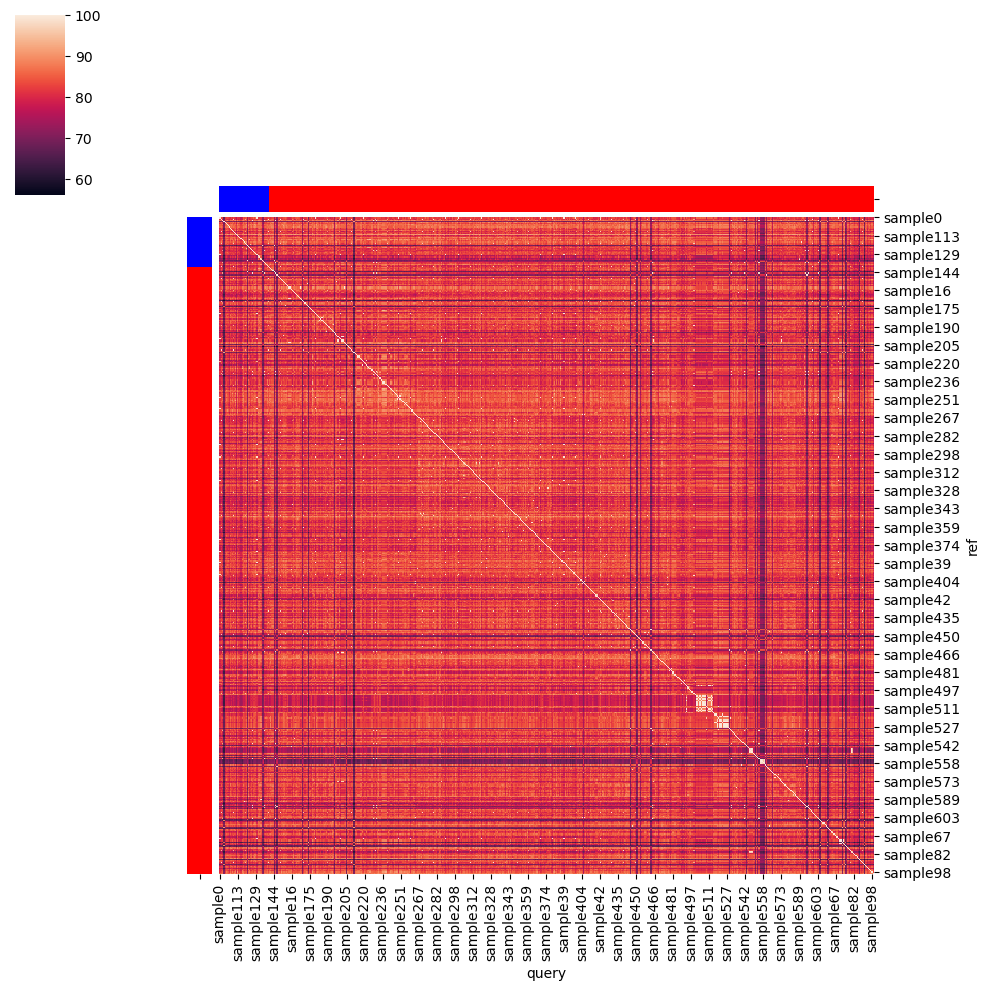

In [36]:
def is_barcode(sample):
    return 'barcode' in sample

skani_matrix['is_barcode_ref'] = skani_matrix['Ref_file'].apply(is_barcode)
skani_matrix['is_barcode_query'] = skani_matrix['Query_file'].apply(is_barcode)

mapped_sample_names = sorted(mapper.values())

sample_colors = pd.Series(['blue' if 'barcode' in name else 'red' for name in sample_names], index=mapped_sample_names)

sns.clustermap(
    new_skani_matrix,
    row_cluster=False, col_cluster=False,
    row_colors=sample_colors.loc[new_skani_matrix.index],
    col_colors=sample_colors.loc[new_skani_matrix.columns]
)

plt.show()

Text(0.5, 1.0, 'skANI (ANI x Alignment)')

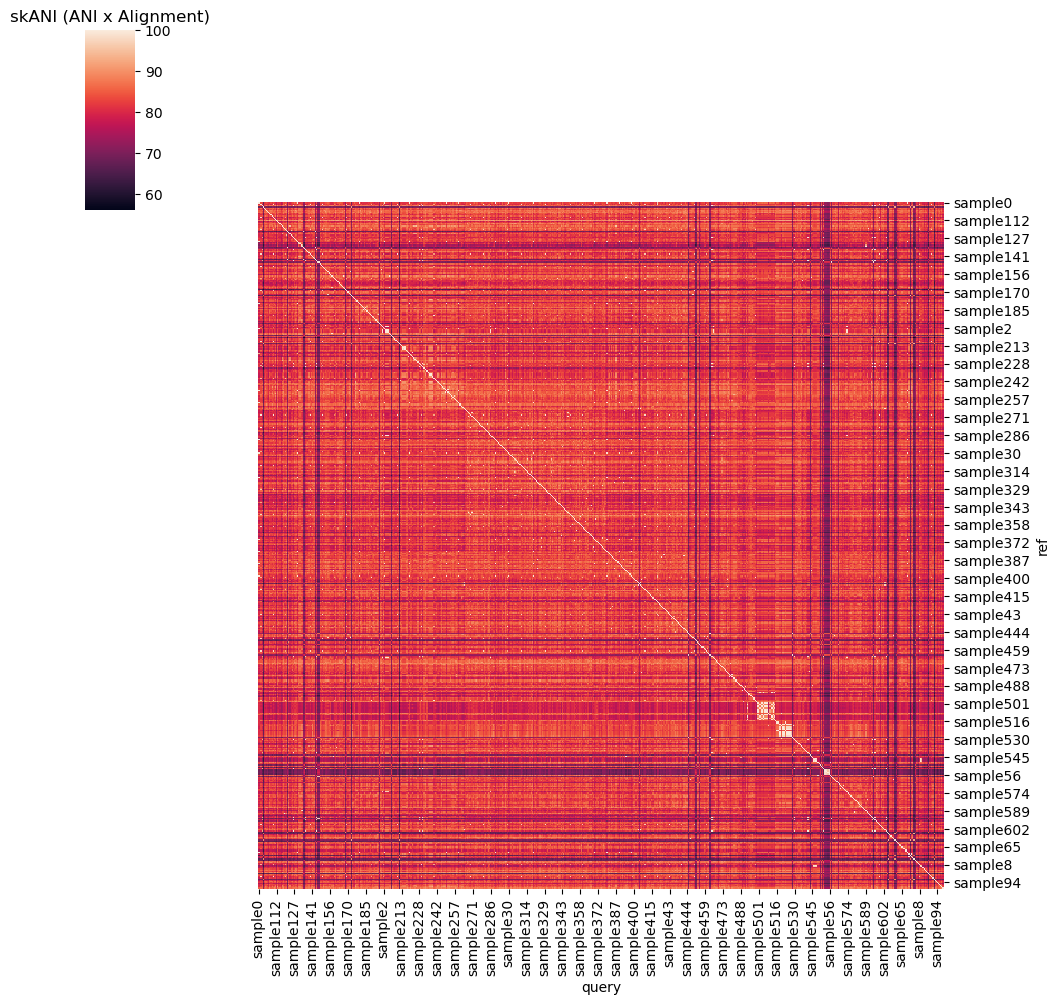

In [7]:
sns.clustermap(new_skani_matrix, row_cluster=False, col_cluster=False)
plt.title("skANI (ANI x Alignment)")

In [8]:
upper_triangle_2 = skani_matrix.pivot(index='ref', columns='query', values='ANI').fillna(0)
upper_triangle_2 = upper_triangle_2[sorted(upper_triangle_2.columns)]

lower_triangle_2 = skani_matrix.pivot(index='query', columns='ref', values='ANI').fillna(0)
lower_triangle_2 = lower_triangle_2[sorted(lower_triangle_2.columns)]

new_skani_matrix_2 = upper_triangle_2 + lower_triangle_2
new_skani_matrix_2[:] = np.where(new_skani_matrix_2==200, 100, new_skani_matrix_2)
new_skani_matrix_2

query      sample0  sample1  sample10  sample100  sample101  sample102  \
ref                                                                      
sample0     100.00   100.00     98.80      98.86      96.75      98.64   
sample1     100.00   100.00     98.80      98.86      96.75      98.64   
sample10     98.80    98.80    100.00      98.49      96.78      98.79   
sample100    98.86    98.86     98.49     100.00      97.15      98.83   
sample101    96.75    96.75     96.78      97.15     100.00      96.74   
...            ...      ...       ...        ...        ...        ...   
sample95     98.80    98.80     98.71      98.91      96.94      98.76   
sample96     98.30    98.30     98.68      98.90      96.74      98.71   
sample97     98.49    98.49     98.74      98.96      96.76      98.89   
sample98     98.50    98.50     98.52      98.97      96.64      98.90   
sample99     98.83    98.83     98.63      98.92      96.79      98.73   

query      sample103  sample104  sample105  sample106  ...  sample90  \
ref                                                    ...             
sample0        98.86      98.80      98.84      98.61  ...     98.56   
sample1        98.86      98.80      98.84      98.61  ...     98.56   
sample10       98.67      98.58      98.60      98.55  ...     98.30   
sample100      98.82      98.97      98.72      98.75  ...     98.78   
sample101      96.87      96.82      96.74      96.77  ...     96.81   
...              ...        ...        ...        ...  ...       ...   
sample95       98.74      98.53      98.71      98.60  ...     98.63   
sample96       98.78      98.88      98.76      98.78  ...     98.90   
sample97       98.91      98.80      98.72      98.68  ...     98.74   
sample98       98.97      98.97      98.72      98.75  ...     98.66   
sample99       98.91      98.86      98.85      98.87  ...     98.92   

query      sample91  sample92  sample93  sample94  sample95  sample96  \
ref                                                                     
sample0       97.13     98.38     98.59     99.01     98.80     98.30   
sample1       97.13     98.38     98.59     99.01     98.80     98.30   
sample10      97.00     98.53     98.60     98.84     98.71     98.68   
sample100     97.25     98.90     98.95     99.15     98.91     98.90   
sample101     99.16     96.48     96.80     96.92     96.94     96.74   
...             ...       ...       ...       ...       ...       ...   
sample95      97.21     98.77     98.82     99.26    100.00     98.86   
sample96      96.80     98.69     98.78     98.89     98.86    100.00   
sample97      96.83     98.60     98.83     99.16     98.33     98.88   
sample98      96.99     98.60     98.84     99.01     99.01     98.90   
sample99      96.84     98.83     98.97     98.90     98.91     98.83   

query      sample97  sample98  sample99  
ref                                      
sample0       98.49     98.50     98.83  
sample1       98.49     98.50     98.83  
sample10      98.74     98.52     98.63  
sample100     98.96     98.97     98.92  
sample101     96.76     96.64     96.79  
...             ...       ...       ...  
sample95      98.33     99.01     98.91  
sample96      98.88     98.90     98.83  
sample97     100.00     99.02     98.83  
sample98      99.02    100.00     98.97  
sample99      98.83     98.97    100.00  

[614 rows x 614 columns]

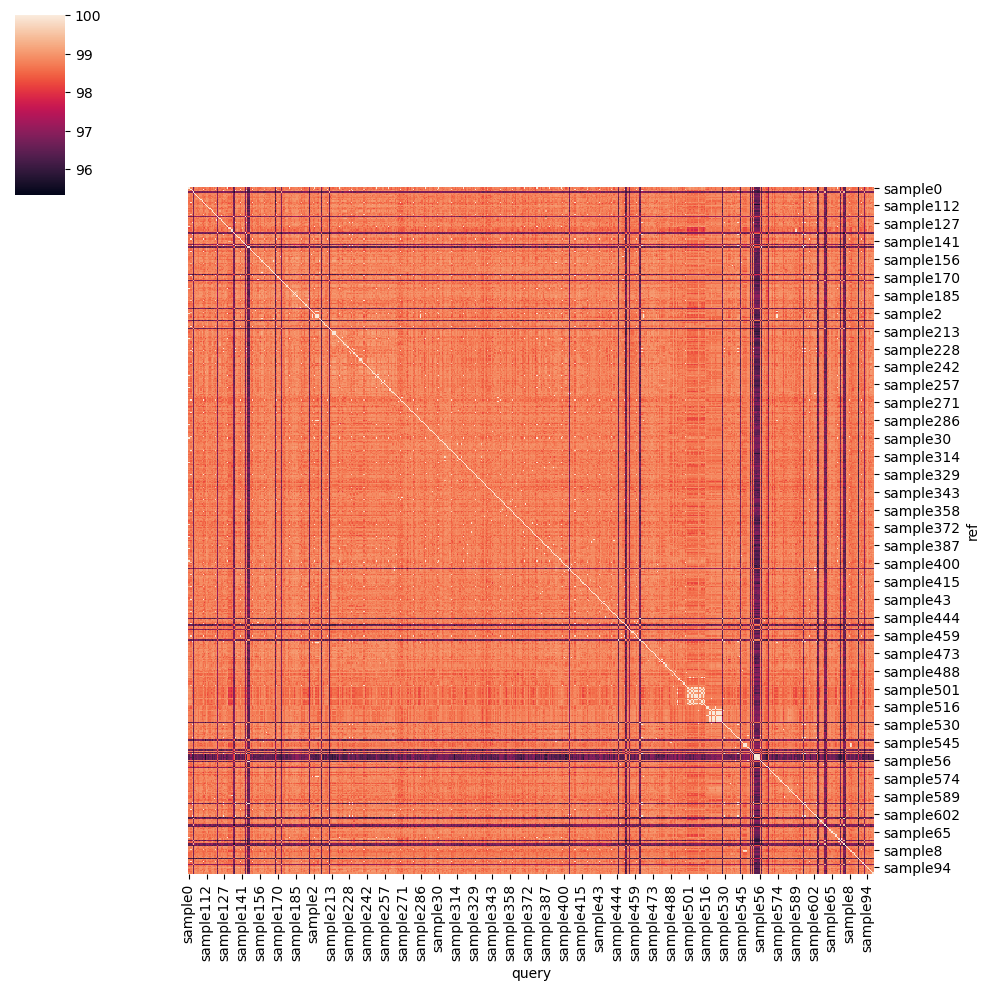

In [31]:
sns.clustermap(new_skani_matrix_2, row_cluster=False, col_cluster=False)
# cbar_pos=(0.05, .3, .03, .4)
# plt.title("skANI (ANI)", fontsize = 20, loc='left')

In [10]:
subsamples = sorted(skani_matrix['ref'].unique())[:10]
submatrix = skani_matrix[(skani_matrix['ref'].isin(subsamples)) & (skani_matrix['query'].isin(subsamples))]

upper_triangle = submatrix.pivot(index='ref', columns='query', values='score1').fillna(0)
upper_triangle = upper_triangle[sorted(upper_triangle.columns)]

lower_triangle = submatrix.pivot(index='query', columns='ref', values='score2').fillna(0)
lower_triangle = lower_triangle[sorted(lower_triangle.columns)]

submatrix = upper_triangle + lower_triangle
submatrix[:] = np.where(submatrix==200, 100, submatrix)
submatrix = 100 - submatrix
submatrix.head(3)

query      sample0   sample1  sample10  sample100  sample101  sample102  \
ref                                                                       
sample0    0.00000   0.03000  16.89932  17.975858  32.420125  18.937648   
sample1    0.03000   0.00000  16.88944  17.975858  32.410450  18.937648   
sample10  19.83368  19.81392   0.00000  22.705048  32.215288  17.875873   

query     sample103  sample104  sample105  sample106  
ref                                                   
sample0   17.738594  16.790640  17.725584  19.317298  
sample1   17.738594  16.790640  17.735468  19.317298  
sample10  18.676186  20.485372  20.005820  21.120580

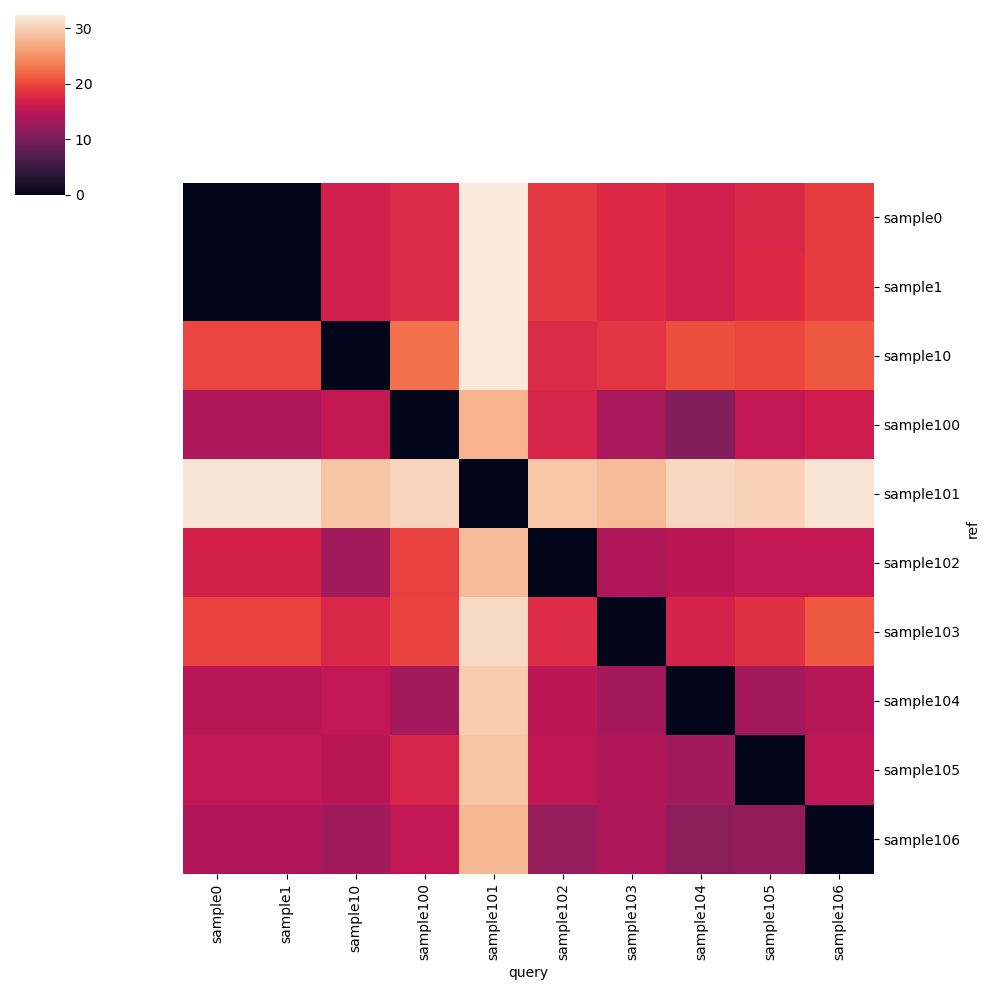

In [11]:
sns.clustermap(submatrix, row_cluster=False, col_cluster=False)

HIERARCHICAL AVERAGE LINKAGE

In [12]:
# distance_matrix = pdist(new_skani_matrix)

In [13]:
fig = plt.figure(figsize=(25, 15))

avg_matrix_w = average(new_skani_matrix)
dendrogram(avg_matrix_w)
plt.show()

KeyboardInterrupt: 

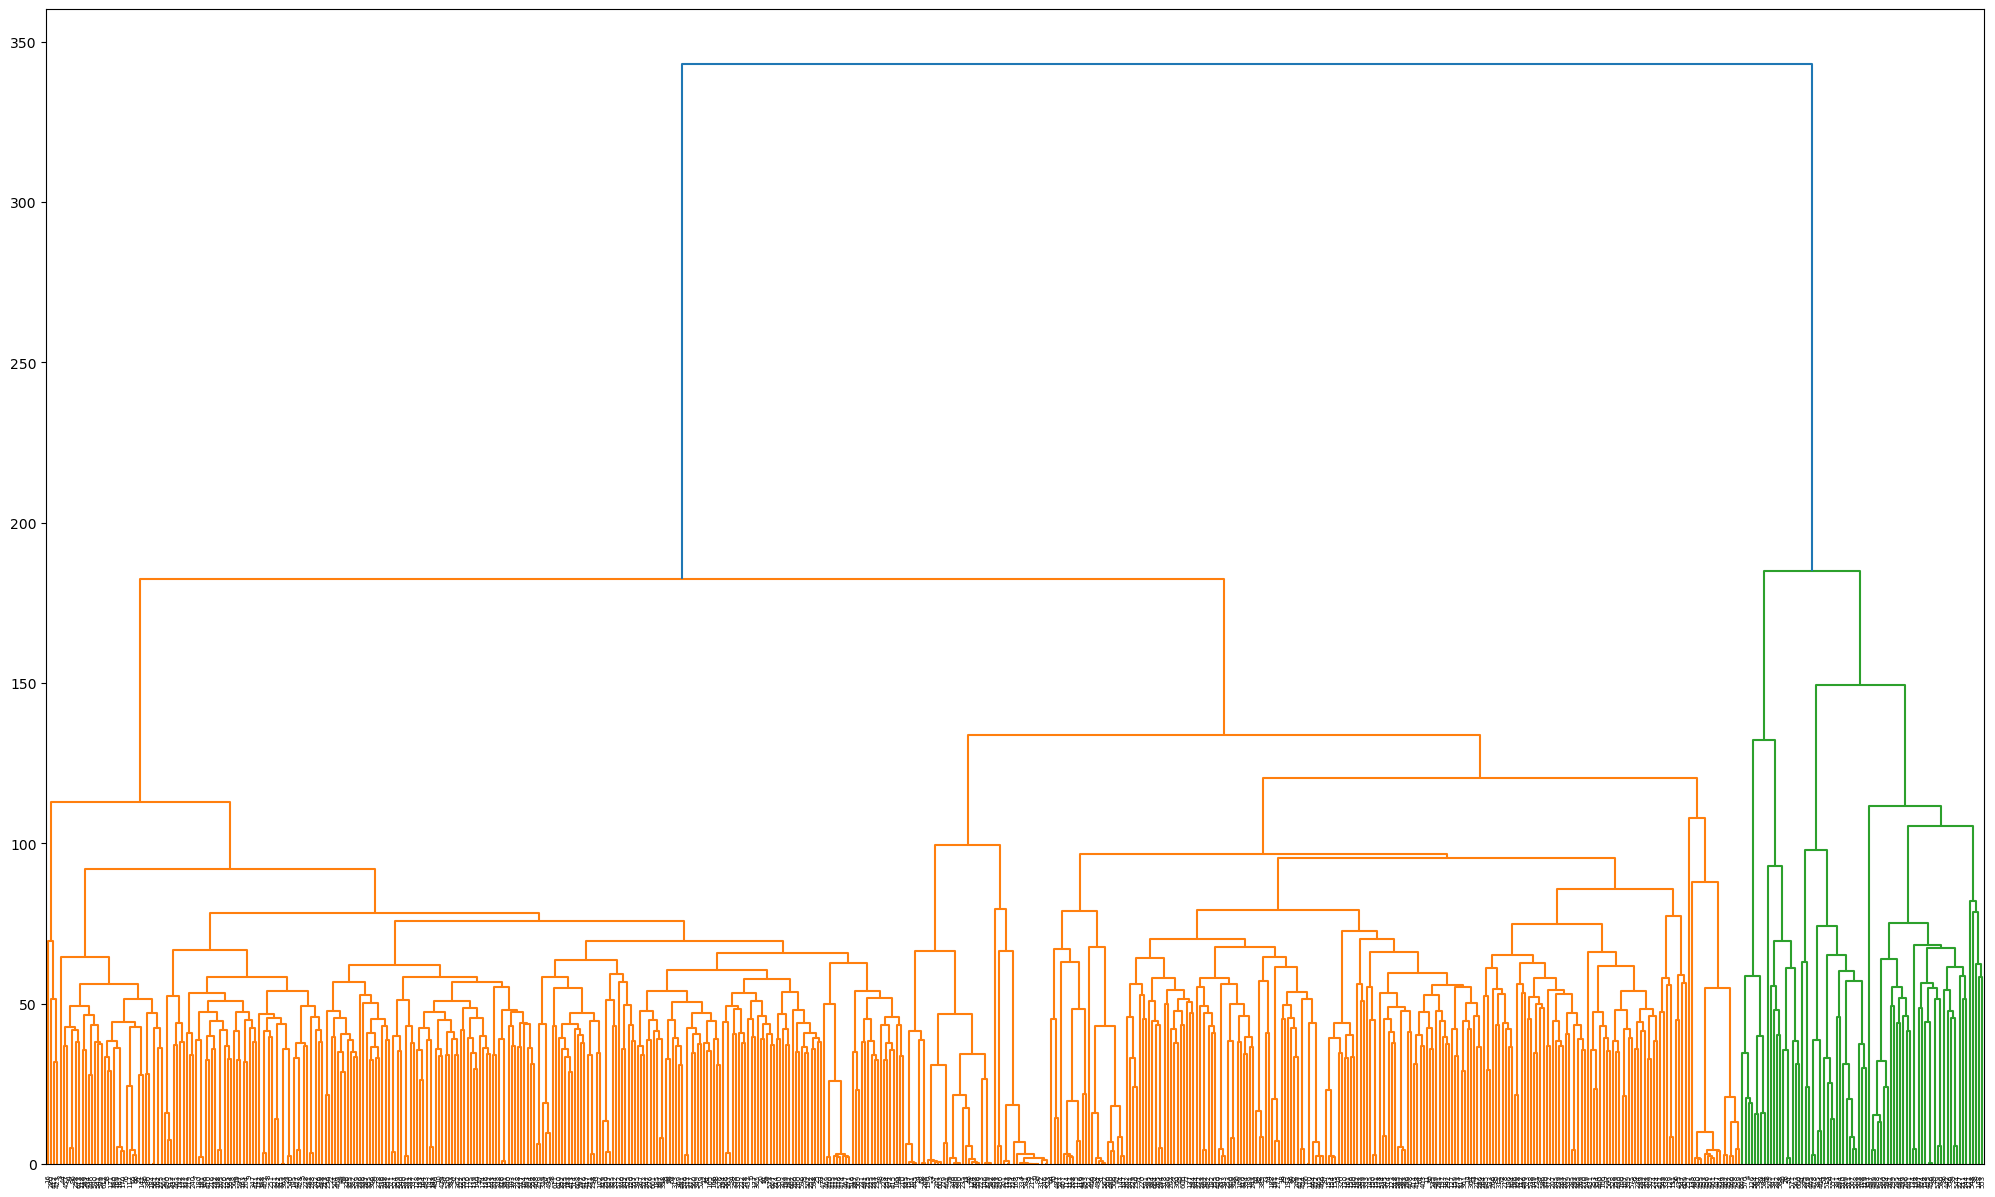

In [ ]:
fig = plt.figure(figsize=(25, 15))

weighted_matrix_w = weighted(new_skani_matrix)
dendrogram(weighted_matrix_w)
plt.show()

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [35.0, 35.0, 60.0, 60.0],
  [85.0, 85.0, 95.0, 95.0],
  [47.5, 47.5, 90.0, 90.0],
  [20.0, 20.0, 68.75, 68.75],
  [5.0, 5.0, 44.375, 44.375]],
 'dcoord': [[0.0,
   np.float64(0.045704633036491395),
   np.float64(0.045704633036491395),
   0.0],
  [0.0, np.float64(17.610133260970347), np.float64(17.610133260970347), 0.0],
  [0.0, np.float64(20.15656194135652), np.float64(20.15656194135652), 0.0],
  [np.float64(17.610133260970347),
   np.float64(21.41541960098238),
   np.float64(21.41541960098238),
   np.float64(20.15656194135652)],
  [0.0,
   np.float64(23.448995036639634),
   np.float64(23.448995036639634),
   np.float64(21.41541960098238)],
  [0.0, np.float64(26.213666702355606), np.float64(26.213666702355606), 0.0],
  [np.float64(23.448995036639634),
   np.float64(27.836657894221574),
   np.float64(27.836657894221574),
   np.float64(26.213666702355606)],
  [np.fl

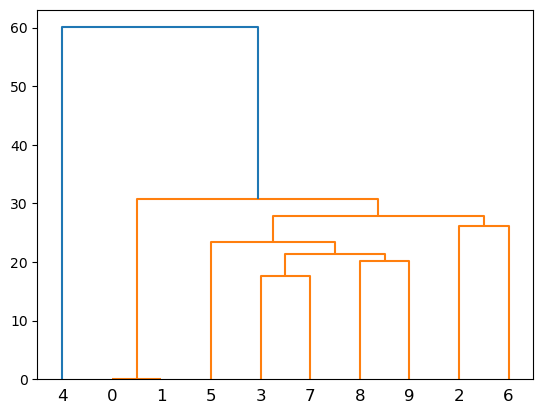

In [ ]:
avg_linkage_matrix = average(submatrix)
avg_dendrogram = dendrogram(avg_linkage_matrix)
avg_dendrogram

In [ ]:
avg_sample_order = leaves_list(avg_linkage_matrix)
avg_sample_order

array([4, 0, 1, 5, 3, 7, 8, 9, 2, 6], dtype=int32)

In [ ]:
t = 0.99*max(avg_linkage_matrix[:,2])
avg_clusters = fcluster(avg_linkage_matrix, t, criterion='distance')
num_avg_clusters = len(set(avg_clusters))
num_avg_clusters

2

In [ ]:
d = dict(zip(submatrix.index, fcluster(avg_linkage_matrix, 1)))
d

{'sample0': np.int32(1),
 'sample1': np.int32(1),
 'sample10': np.int32(1),
 'sample100': np.int32(1),
 'sample101': np.int32(1),
 'sample102': np.int32(1),
 'sample103': np.int32(1),
 'sample104': np.int32(1),
 'sample105': np.int32(1),
 'sample106': np.int32(1)}

In [ ]:
def getvalue(n):
    return d.get(n)

sorted(d, key=getvalue)

['sample0',
 'sample1',
 'sample10',
 'sample100',
 'sample101',
 'sample102',
 'sample103',
 'sample104',
 'sample105',
 'sample106']

<Axes: xlabel='query', ylabel='ref'>

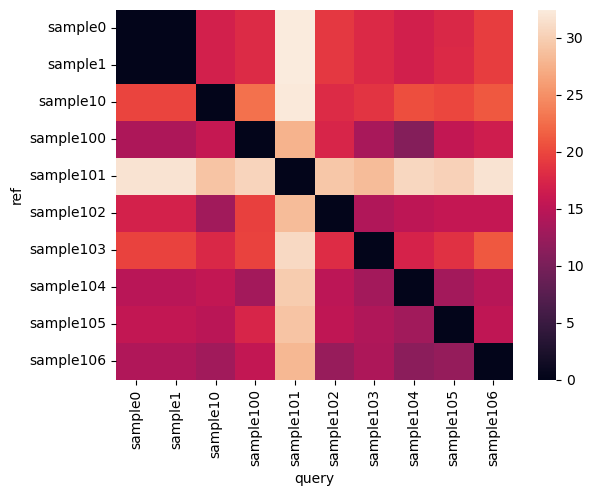

In [ ]:
order = sorted(d, key=lambda n: d.get(n))

osubmatrix = submatrix[order]
osubmatrix = osubmatrix.reindex(order)

sns.heatmap(osubmatrix)

(<seaborn.matrix.ClusterGrid at 0x168c01130>,
 (query      sample100  sample104  sample105  sample106    sample0    sample1  \
  ref                                                                           
  sample100   0.000000  10.867618  15.466064  16.576000  13.803966  13.803966   
  sample104  13.074649   0.000000  13.102392  14.681272  14.725720  14.725720   
  sample105  17.420720  12.954372   0.000000  15.298240  15.541220  15.541220   
  sample106  15.460125  11.345888  12.129328   0.000000  14.081107  14.081107   
  sample0    17.975858  16.790640  17.725584  19.317298   0.000000   0.030000   
  sample1    17.975858  16.790640  17.735468  19.317298   0.030000   0.000000   
  sample10   22.705048  20.485372  20.005820  21.120580  19.833680  19.813920   
  sample102  19.611678  15.179264  15.630904  15.689133  17.093080  17.093080   
  sample103  19.629694  17.181140  18.388176  21.085604  19.686136  19.686136   
  sample101  30.518320  30.764018  30.192416  31.777150  31.752

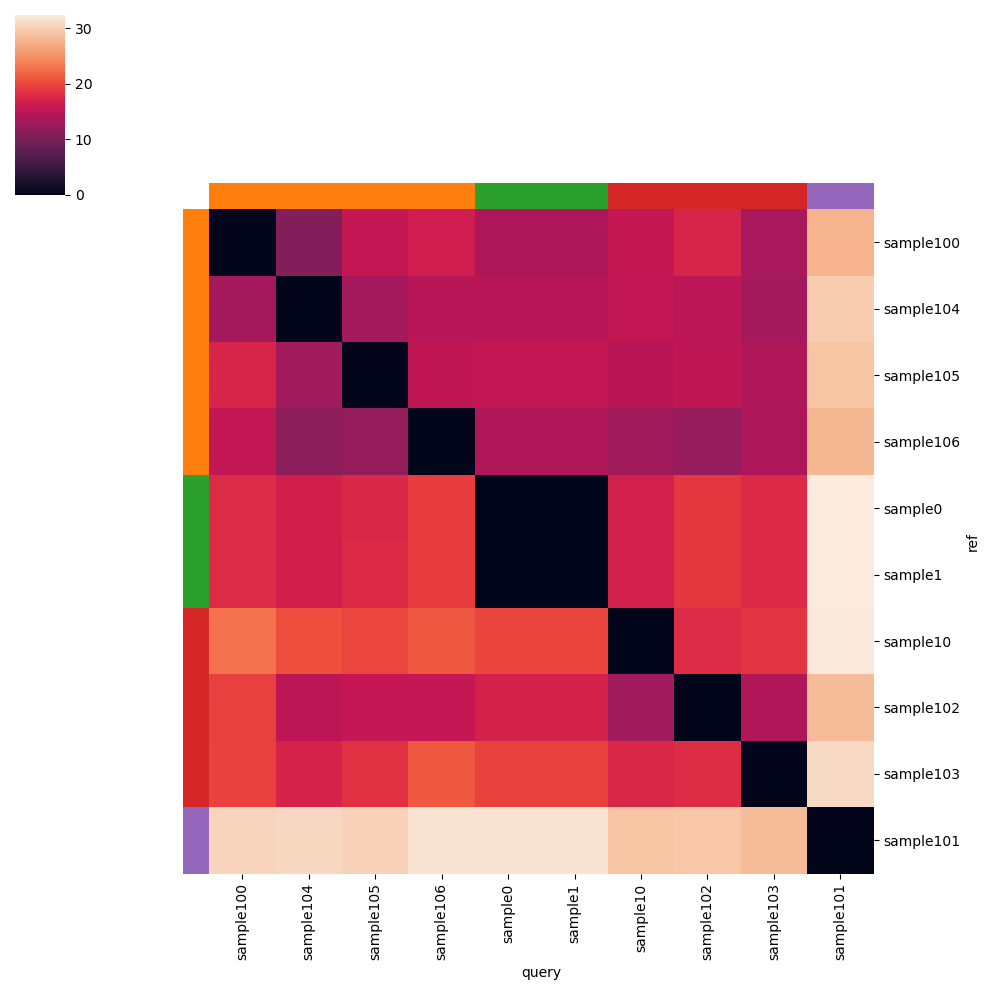

In [ ]:
def get_clustered_matrix(distance_matrix, cluster_function, threshold, criterion, kwargs={}):
    
    a = np.array(distance_matrix)
    a = a[np.triu_indices_from(a, k=1)]
    
    try:
        clustering = cluster_function(a, metric=None, ** kwargs)
    except TypeError:
        clustering = cluster_function(a, ** kwargs)

    # get the order
    d = dict(zip(submatrix.index, fcluster(clustering, threshold, criterion)))
    order = sorted(d, key=lambda n: d.get(n))
    
    # reorder frame
    nframe = distance_matrix.copy()
    nframe = nframe[order]
    return nframe.reindex(order), d

res = get_clustered_matrix(submatrix, ward, 20, 'distance')

colors = list(sns.color_palette())
colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors), res

(np.float64(22.705048000000005), np.float64(11.345887999999988))

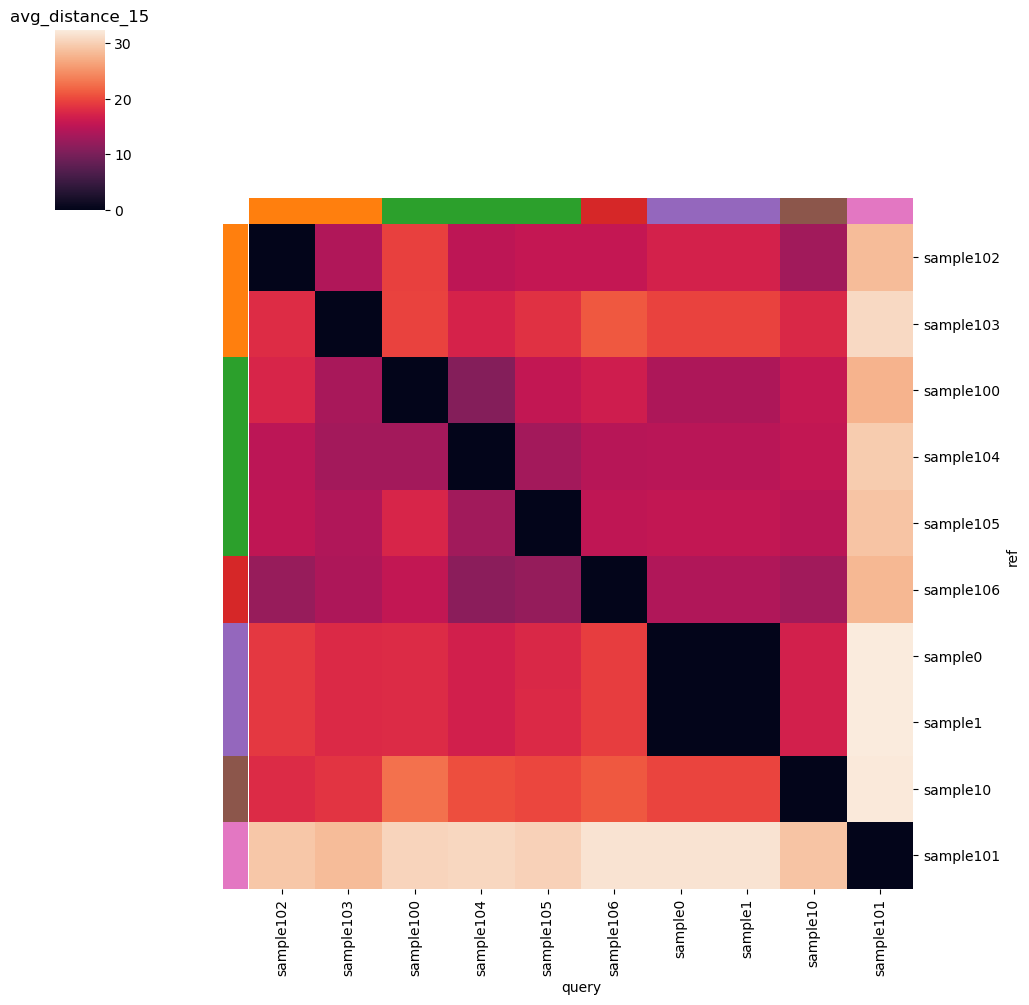

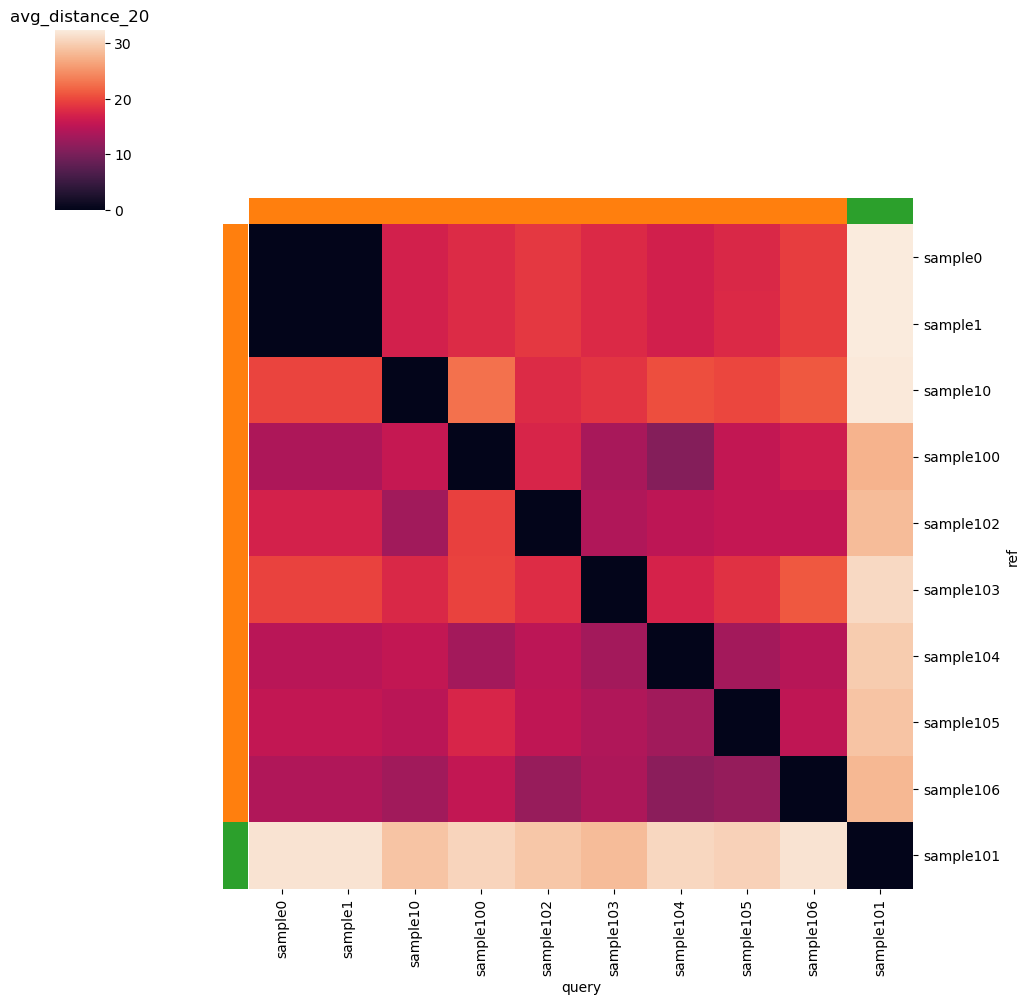

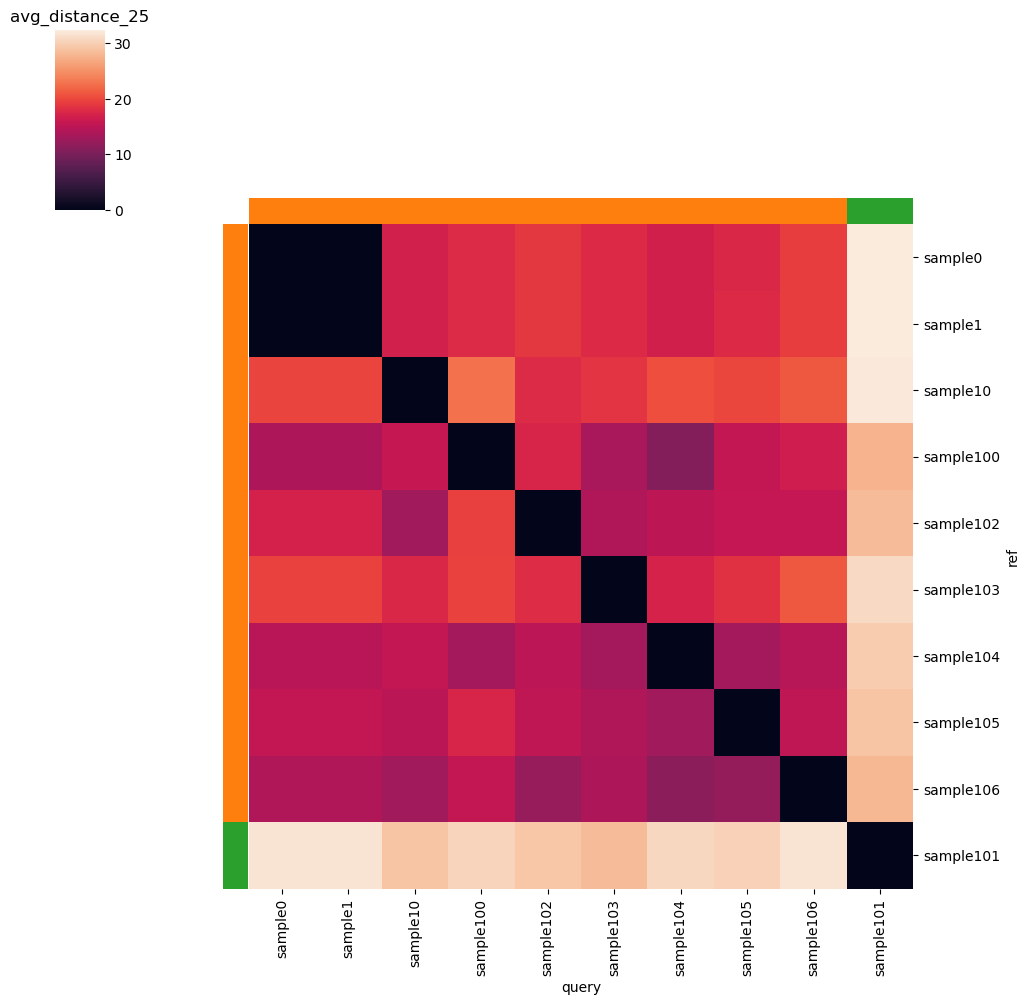

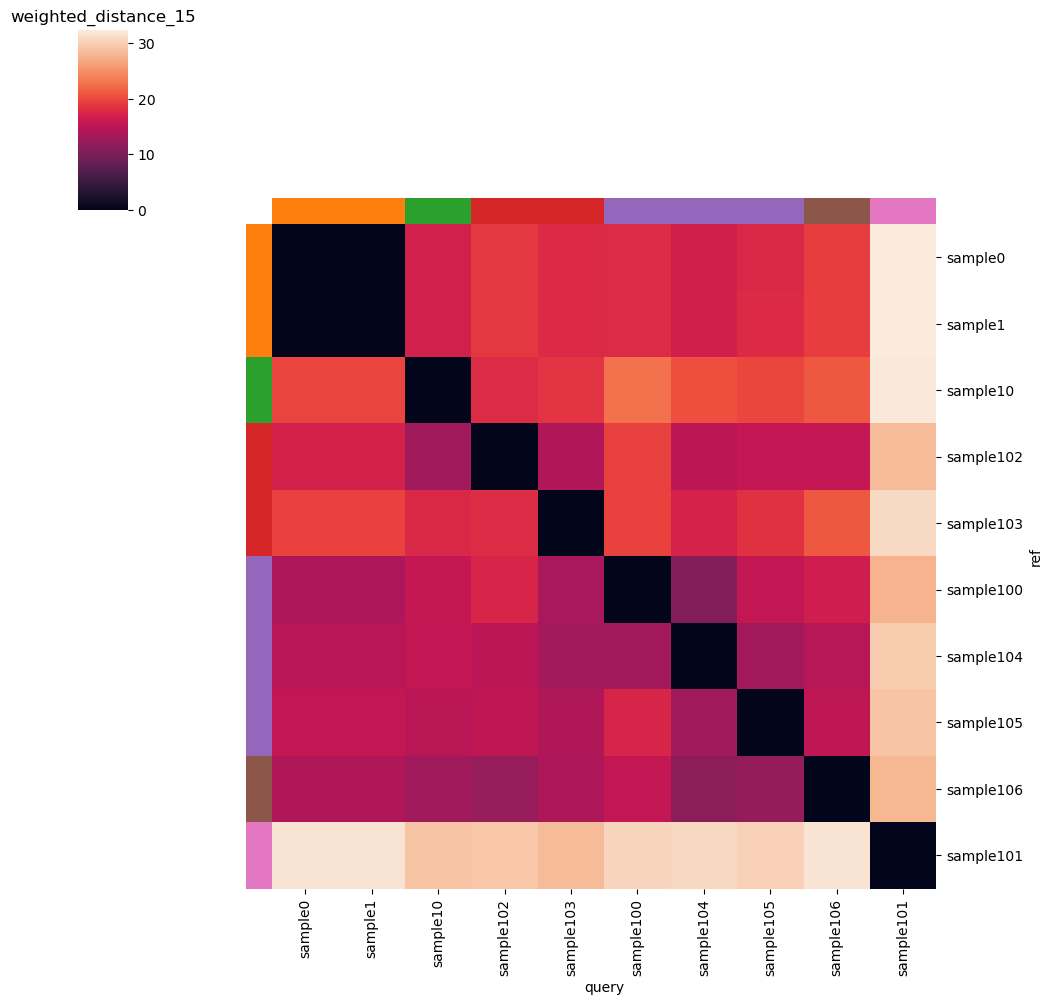

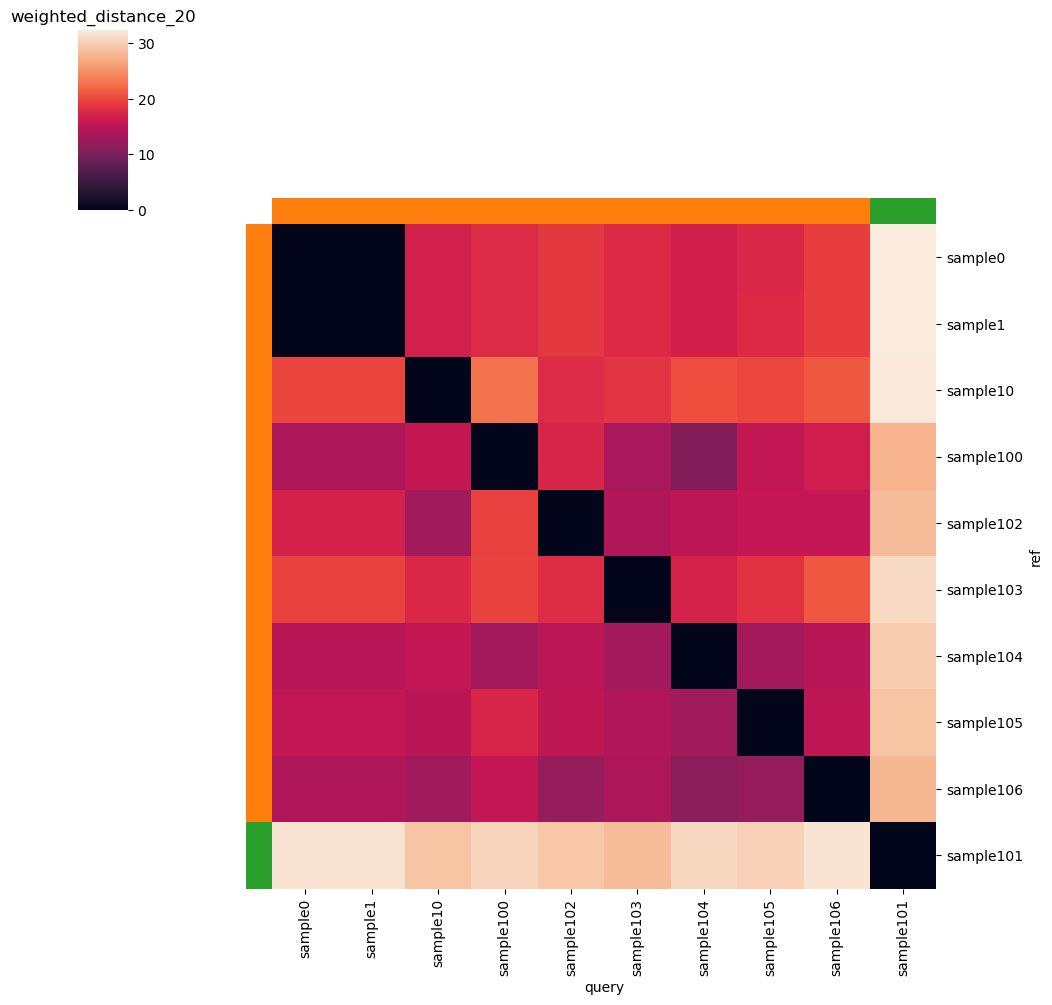

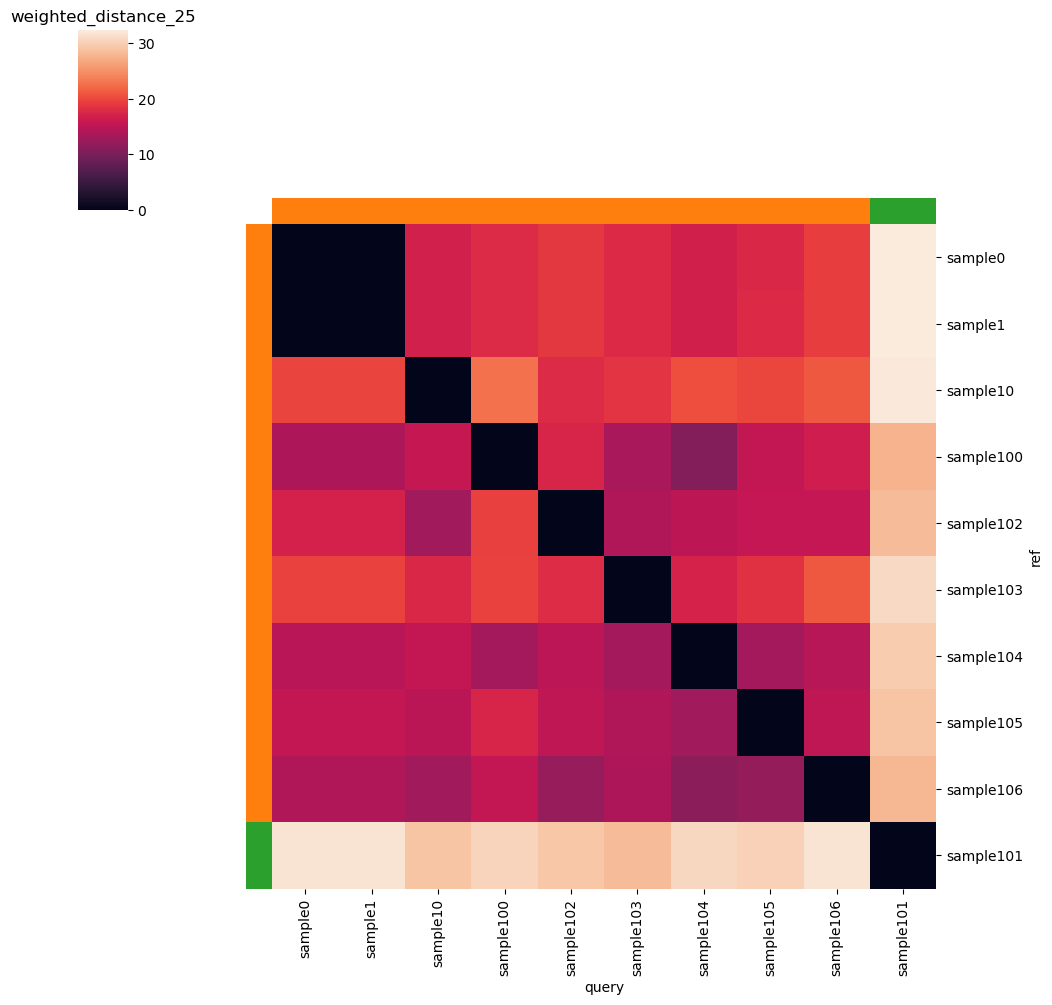

In [ ]:
def get_clusters_stats(res):
    matrix, clustering = res
    nclusters = len(set(clustering.values()))

    matrix = matrix.melt(ignore_index=False, value_name='distance').reset_index()
    matrix['ss1c'] = matrix['ref'].apply(lambda key: clustering[key])
    matrix['ss2c'] = matrix['query'].apply(lambda key: clustering[key])

    smatrix = matrix[matrix['ref'] != matrix['query']]
    same_smatrix = smatrix[smatrix['ss1c'] == smatrix['ss2c']]
    intra_sim = same_smatrix.groupby('ss1c')['distance'].describe().reset_index()

    notsame_smatrix = smatrix[smatrix['ss1c'] != smatrix['ss2c']]
    inter_sim = notsame_smatrix.groupby(['ss1c', 'ss2c'])['distance'].describe().reset_index()

    return nclusters, intra_sim, inter_sim

d = {
    # 'ward_distance_1': (ward, 1, 'distance', {}),
    # 'ward_distance_15': (ward, 15, 'distance', {}),
    # 'ward_distance_20': (ward, 20, 'distance', {}),
    # 'ward_distance_25': (ward, 25, 'distance', {}),
    # 'avg_distance_1': (average, 1, 'distance', {}),
    'avg_distance_15': (average, 15, 'distance', {}),
    'avg_distance_20': (average, 20, 'distance', {}),
    'avg_distance_25': (average, 25, 'distance', {}),
    'weighted_distance_15': (weighted, 15, 'distance', {}),
    'weighted_distance_20': (weighted, 20, 'distance', {}),
    'weighted_distance_25': (weighted, 25, 'distance', {})
    # 'linkage_distance_1': (linkage, 1, 'distance'),
    # 'linkage_distance_15': (linkage, 15, 'distance'),
    # 'linkage_distance_20': (linkage, 20, 'distance'),
    # 'linkage_distance_25': (linkage, 25, 'distance'),
    # 'linkage_complete_distance_10': (linkage, 10, 'distance', {'method': 'complete'}),
    # 'linkage_complete_distance_15': (linkage, 15, 'distance', {'method': 'complete'}),
    # 'linkage_complete_distance_20': (linkage, 20, 'distance', {'method': 'complete'}),
    # 'linkage_complete_distance_25': (linkage, 25, 'distance', {'method': 'complete'})
}

allres_ncluster = {}
allres_intra = []
allres_inter = []

for method_name, values in d.items():
    res = get_clustered_matrix(submatrix, * values)
    stats = get_clusters_stats(res)
    ncluster, intra, inter = stats
    
    allres_ncluster[method_name] = ncluster
    intra['method'] = method_name
    allres_intra.append(intra)
    
    inter['method'] = method_name
    allres_inter.append(inter)

    colors = list(sns.color_palette())
    colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

    sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors)
    plt.title(method_name)
    
allres_ncluster = pd.Series(allres_ncluster)
allres_ncluster = allres_ncluster.to_frame().reset_index()
allres_ncluster.columns = ['method', 'nclusters']

allres_inter = pd.concat(allres_inter)
allres_intra = pd.concat(allres_intra)

allres_intra['max'].max(), allres_inter['min'].min()

<Axes: xlabel='min', ylabel='method'>

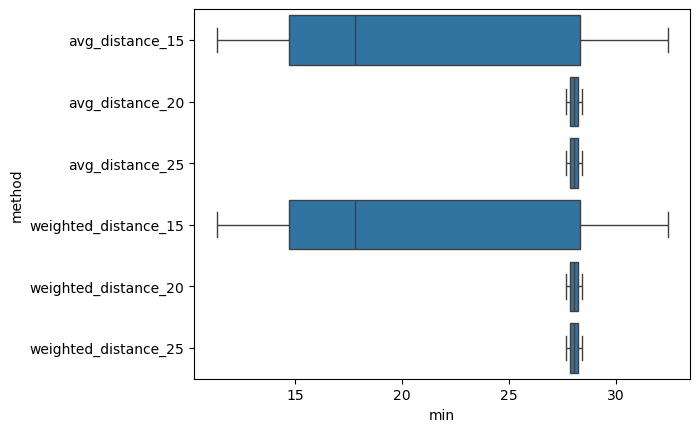

In [ ]:
sns.boxplot(allres_inter, y='method', x='min')

<Axes: xlabel='mean', ylabel='method'>

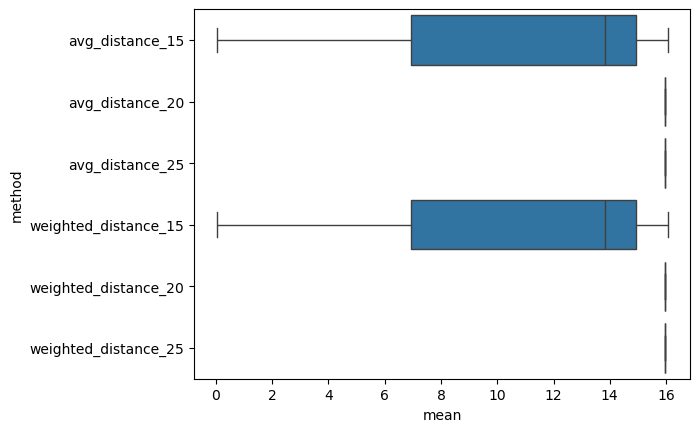

In [ ]:
sns.boxplot(allres_intra, y='method', x='mean')

In [ ]:
allres_intra.groupby('method')['mean'].describe()

count       mean       std        min        25%  \
method                                                                   
avg_distance_15         3.0   9.966560  8.677962   0.030000   6.922151   
avg_distance_20         1.0  15.950556       NaN  15.950556  15.950556   
avg_distance_25         1.0  15.950556       NaN  15.950556  15.950556   
weighted_distance_15    3.0   9.966560  8.677962   0.030000   6.922151   
weighted_distance_20    1.0  15.950556       NaN  15.950556  15.950556   
weighted_distance_25    1.0  15.950556       NaN  15.950556  15.950556   

                            50%        75%        max  
method                                                 
avg_distance_15       13.814303  14.934840  16.055377  
avg_distance_20       15.950556  15.950556  15.950556  
avg_distance_25       15.950556  15.950556  15.950556  
weighted_distance_15  13.814303  14.934840  16.055377  
weighted_distance_20  15.950556  15.950556  15.950556  
weighted_distance_25  15.950556  15.950556  15.950556

<Axes: xlabel='nclusters', ylabel='method'>

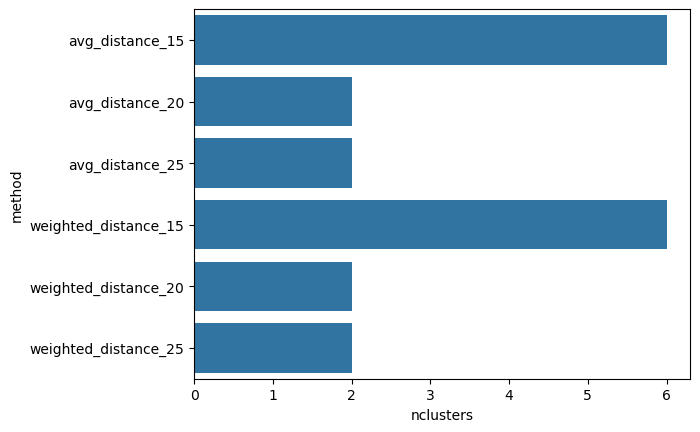

In [ ]:
sns.barplot(allres_ncluster, y='method', x='nclusters')

In [ ]:
def get_clustered_matrix_w(distance_matrix, cluster_function, threshold, criterion, kwargs={}):
    
    a = np.array(distance_matrix)
    a = a[np.triu_indices_from(a, k=1)]
    
    try:
        clustering = cluster_function(a, metric=None, ** kwargs)
    except TypeError:
        clustering = cluster_function(a, ** kwargs)

    d = dict(zip(new_skani_matrix.index, fcluster(clustering, threshold, criterion)))
    order = sorted(d, key=lambda n: d.get(n))
    
    nframe = distance_matrix.copy()
    nframe = nframe[order]
    return nframe.reindex(order), d

colors = list(sns.color_palette())
colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

# sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors), res

def get_clusters_stats_w(res):
    matrix, clustering = res
    nclusters = len(set(clustering.values()))

    matrix = matrix.melt(ignore_index=False, value_name='distance').reset_index()
    matrix['ss1c'] = matrix['ref'].apply(lambda key: clustering[key])
    matrix['ss2c'] = matrix['query'].apply(lambda key: clustering[key])

    smatrix = matrix[matrix['ref'] != matrix['query']]
    same_smatrix = smatrix[smatrix['ss1c'] == smatrix['ss2c']]
    intra_sim = same_smatrix.groupby('ss1c')['distance'].describe().reset_index()

    notsame_smatrix = smatrix[smatrix['ss1c'] != smatrix['ss2c']]
    inter_sim = notsame_smatrix.groupby(['ss1c', 'ss2c'])['distance'].describe().reset_index()

    return nclusters, intra_sim, inter_sim

d = {
    # 'ward_distance_1': (ward, 1, 'distance', {}),
    # 'ward_distance_15': (ward, 15, 'distance', {}),
    # 'ward_distance_20': (ward, 20, 'distance', {}),
    # 'ward_distance_25': (ward, 25, 'distance', {}),
    # 'avg_distance_1': (average, 1, 'distance', {}),
    'avg_distance_15': (average, 15, 'distance', {}),
    'avg_distance_20': (average, 20, 'distance', {}),
    'avg_distance_25': (average, 25, 'distance', {}),
    'weighted_distance_15': (weighted, 15, 'distance', {}),
    'weighted_distance_20': (weighted, 20, 'distance', {}),
    'weighted_distance_25': (weighted, 25, 'distance', {})
    # 'linkage_distance_1': (linkage, 1, 'distance'),
    # 'linkage_distance_15': (linkage, 15, 'distance'),
    # 'linkage_distance_20': (linkage, 20, 'distance'),
    # 'linkage_distance_25': (linkage, 25, 'distance'),
    # 'linkage_complete_distance_10': (linkage, 10, 'distance', {'method': 'complete'}),
    # 'linkage_complete_distance_15': (linkage, 15, 'distance', {'method': 'complete'}),
    # 'linkage_complete_distance_20': (linkage, 20, 'distance', {'method': 'complete'}),
    # 'linkage_complete_distance_25': (linkage, 25, 'distance', {'method': 'complete'})
}

allres_ncluster_w = {}
allres_intra_w = []
allres_inter_w = []

for method_name, values in d.items():
    res = get_clustered_matrix_w(new_skani_matrix, * values)
    stats = get_clusters_stats_w(res)
    ncluster, intra, inter = stats
    
    allres_ncluster_w[method_name] = ncluster
    intra['method'] = method_name
    allres_intra_w.append(intra)
    
    inter['method'] = method_name
    allres_inter_w.append(inter)

    colors = list(sns.color_palette())
    colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

    sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors)
    plt.title(method_name)
    
allres_ncluster_w = pd.Series(allres_ncluster_w)
allres_ncluster_w = allres_ncluster_w.to_frame().reset_index()
allres_ncluster_w.columns = ['method', 'nclusters']

allres_inter_w = pd.concat(allres_inter_w)
allres_intra_w = pd.concat(allres_intra_w)

allres_intra_w['max'].max(), allres_inter_w['min'].min()

KeyboardInterrupt: 

Threshold 10: 567 clusters
Threshold 50: 567 clusters
Threshold 60: 564 clusters
Threshold 70: 507 clusters
Threshold 80: 251 clusters
Threshold 85: 40 clusters
Threshold 90: 2 clusters
Threshold 100: 1 clusters


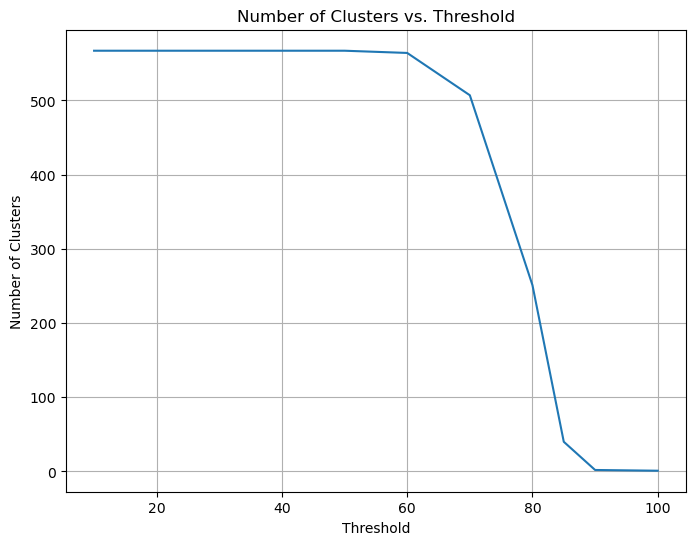

In [ ]:
threshold_values = [10, 50, 60, 70, 80, 85, 90, 100]
results = {}

for threshold in threshold_values:
    res = get_clustered_matrix_w(new_skani_matrix, weighted, threshold, 'distance')
    clusters = res[1]
    num_clusters = len(set(clusters.values()))
    results[threshold] = num_clusters
    print(f"Threshold {threshold}: {num_clusters} clusters")

plt.figure(figsize=(8, 6))
plt.plot(list(results.keys()), list(results.values()))
plt.title('Number of Clusters vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.show()

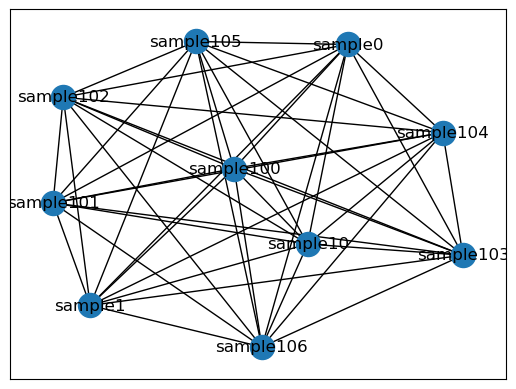

In [ ]:
edges = []

for i, row in submatrix.iterrows():
    for j, value in row.items():
        if i != j:
            edges.append((i, j, value))

G_sub = nx.Graph()
G_sub.add_weighted_edges_from(edges)

pos = nx.spring_layout(G_sub)

# plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G_sub, pos=pos)
nx.draw_networkx_edges(G_sub, pos=pos, edgelist=G_sub.edges(data=True))
nx.draw_networkx_labels(G_sub, pos=pos)

plt.show()

HIERARCHICAL WARD LINKAGE

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [13.75, 13.75, 60.0, 60.0],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [90.0, 90.0, 110.0, 110.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [100.0, 100.0, 132.5, 132.5],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [155.0, 155.0, 172.5, 172.5],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [225.0, 225.0, 242.5, 242.5],
  [202.5, 202.5, 233.75, 233.75],
  [163.75, 163.75, 218.125, 218.125],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [275.0, 275.0, 292.5, 292.5],
  [265.0, 265.0, 283.75, 283.75],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 340.0, 340.0],
  [315.0, 315.0, 332.5, 332.5],
  [365.0, 365.0, 375.0, 375.0],
  [355.0, 355.0, 370.0

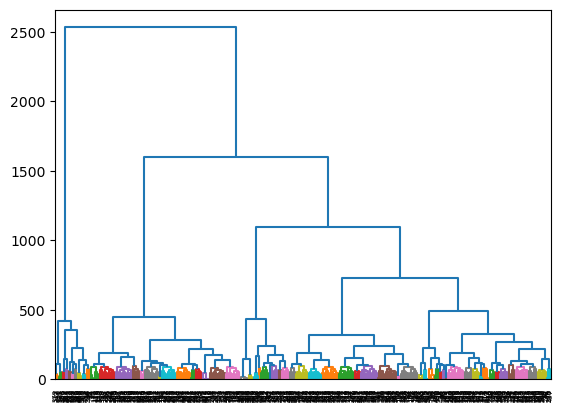

In [ ]:
ward_linkage_matrix = ward(distance_matrix)
ward_dendrogram = dendrogram(ward_linkage_matrix, color_threshold=99)
ward_dendrogram

In [ ]:
ward_sample_order = leaves_list(ward_linkage_matrix)
ward_sample_order

array([379, 517,  73, 490, 201, 511,  31, 168, 353, 426, 332, 352, 554,
       343, 467, 453, 288, 212, 340, 553, 539, 564,  27, 518, 335, 510,
       459, 458, 460, 455, 456, 566, 461,   3, 499, 451,  56,  66, 339,
       441,  25,  64,  14,  15, 117, 116, 118, 457,   6, 119, 132, 508,
       479,  28, 333, 147, 153,  65, 224,  88, 535, 109, 222,  42,  44,
       334, 558, 205, 468, 425, 280, 167, 187,  46, 301, 532, 110, 152,
       522, 294, 360, 254, 359, 164, 180, 520, 128, 129, 529, 228,   0,
         1, 112, 223, 489, 235, 323, 545, 534, 556, 385, 410, 229, 237,
       162, 297, 189, 324, 436, 375, 376, 143, 227, 501, 345, 347, 194,
       225, 267, 197, 275,  90, 101, 120, 173,  72, 471, 503, 337, 350,
       198, 521, 270, 271, 263, 310, 494, 537, 114, 526, 327,  29, 296,
       115,  37, 474, 446, 541, 463, 131, 361, 299, 434, 412, 462, 445,
       523, 277,  16, 442, 287, 289, 273, 281, 519, 473,  35,  67, 416,
       417, 422, 420, 424, 421, 415, 418, 316, 428,  11, 261,   

In [ ]:
t = 0.99*max(ward_linkage_matrix[:,2])
ward_clusters = fcluster(ward_linkage_matrix, t, criterion='distance')
num_ward_clusters = len(set(ward_clusters))
num_ward_clusters

2

COMPARING CLUSTERING METHODS

In [ ]:
cluster_counts = {}
cluster_counts["Average Linkage"] = num_avg_clusters
cluster_counts["Ward Linkage"] = num_ward_clusters
cluster_counts

{'Average Linkage': 2, 'Ward Linkage': 2}

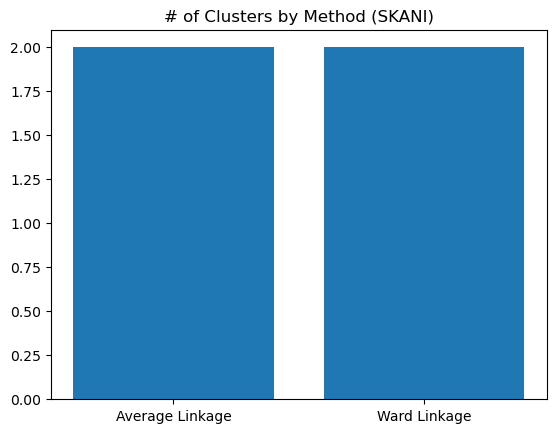

In [ ]:
plt.bar(cluster_counts.keys(), cluster_counts.values())
plt.title("# of Clusters by Method (SKANI)")
plt.show()